In [1]:
# modeling notebook enhanced by https://claude.ai/

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (classification_report, accuracy_score, 
                            confusion_matrix, ConfusionMatrixDisplay, 
                            roc_curve, auc)
from sklearn.preprocessing import label_binarize
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from scipy.stats import randint, uniform
import time
import os
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier



In [2]:
# Create directories for saving results
os.makedirs('results', exist_ok=True)
os.makedirs('results/baseline', exist_ok=True)
os.makedirs('results/hybrid', exist_ok=True)

In [3]:
# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

In [4]:
dataset_type = 'hybrid'

print(f"\n{'='*80}")
print(f"    MODELING PIPELINE FOR {dataset_type.upper()} DATASET")
print(f"{'='*80}\n")

# Step 1: Exploratory Data Analysis (EDA)
print("\n" + "="*50)
print("1. EXPLORATORY DATA ANALYSIS")
print("="*50)

# Load the dataset
train_path = f'../data/train_{dataset_type}.csv'
test_path = f'../data/test_{dataset_type}.csv'

try:
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    print(f"Successfully loaded {dataset_type} datasets:")
    print(f"Training shape: {train_df.shape}")
    print(f"Testing shape: {test_df.shape}")
except FileNotFoundError:
    print(f"Error: Could not find {dataset_type} dataset files. Please check file paths.")
else:
    # Basic dataset information
    print("\nTraining Dataset Overview:")
    print(f"Columns: {train_df.columns.tolist()}")
    print("\nData Types:")
    print(train_df.dtypes)

    # Target distribution
    target_col = 'Event Classification'
    target_dist = train_df[target_col].value_counts(normalize=True).reset_index()
    target_dist.columns = ['Class', 'Proportion']
    print("\nTarget Distribution:")
    print(target_dist)

    # Visualize target distribution
    os.makedirs(f'results/{dataset_type}', exist_ok=True)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Class', y='Proportion', data=target_dist)
    plt.title(f'Target Distribution - {dataset_type.capitalize()} Dataset')
    plt.ylabel('Proportion')
    plt.savefig(f'results/{dataset_type}/target_distribution.png', dpi=300, bbox_inches='tight')
    plt.close()



    MODELING PIPELINE FOR HYBRID DATASET


1. EXPLORATORY DATA ANALYSIS
Successfully loaded hybrid datasets:
Training shape: (76065, 330)
Testing shape: (19017, 330)

Training Dataset Overview:
Columns: ['Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Years_Since_First', 'Is_US', 'ProductClassification_Class II', 'ProductClassification_Class III', 'ProductType_Devices', 'ProductType_Drugs', 'ProductType_Food/Cosmetics', 'ProductType_Tobacco', 'ProductType_Veterinary', 'Status_Ongoing', 'Status_Terminated', 'Business_Structure_Association', 'Business_Structure_Company', 'Business_Structure_Corporation', 'Business_Structure_Inc', 'Business_Structure_LLC', 'Business_Structure_LLP', 'Business_Structure_LP', 'Business_Structure_Ltd', 'Business_Structure_Non-Profit', 'Business_Structure_Other', 'Business_Structure_PLC', 'Business_Structure_SA', 'text_svd_0', 'text_svd_1', 'text_svd_2', 'text_svd_3', 'text_svd_4', 'text_svd_5', 'text_svd_6', 'text_svd_7', '

In [5]:
# Step 2: Data Cleaning (Validation)
print("\n" + "="*50)
print("2. DATA CLEANING VALIDATION")
print("="*50)

# Check for missing values
missing_values = train_df.isnull().sum()
print("\nMissing values in training data:")
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values found")

# Step 3: Data Preparation
print("\n" + "="*50)
print("3. DATA PREPARATION")
print("="*50)

# Define features (X) and target (y)
X_train = train_df.drop(target_col, axis=1)
y_train = train_df[target_col]
X_test = test_df.drop(target_col, axis=1)
y_test = test_df[target_col]

# Ensure test data has the same columns as train data
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
X_test = X_test[X_train.columns]

# Encode target
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

class_names = le.classes_
print(f"Target Classes: {class_names}")



2. DATA CLEANING VALIDATION

Missing values in training data:
No missing values found

3. DATA PREPARATION
Target Classes: ['Class I' 'Class II' 'Class III']


In [6]:
# Step 4: Train-Test Split Validation
print("\n" + "="*50)
print("4. TRAIN-TEST SPLIT VALIDATION")
print("="*50)

# The split was done in preprocessing, but validate proportions
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])
print("Test set proportion: {:.2f}%".format(100 * X_test.shape[0] / (X_train.shape[0] + X_test.shape[0])))

print("\nTraining class distribution:")
print(pd.Series(y_train_encoded).value_counts(normalize=True))

print("\nTest class distribution:")
print(pd.Series(y_test_encoded).value_counts(normalize=True))

# Step 5: Feature Engineering Validation
print("\n" + "="*50)
print("5. FEATURE ENGINEERING VALIDATION")
print("="*50)

# Display number of features
print(f"Number of features: {X_train.shape[1]}")

# Display feature categories
temporal_features = [col for col in X_train.columns if any(x in col for x in ['Month', 'Day', 'Year', 'Week'])]
text_features = [col for col in X_train.columns if 'text_svd_' in col]
categorical_features = [col for col in X_train.columns if any(x in col for x in ['Classification', 'Type', 'Status', 'Structure'])]

print(f"Temporal features: {len(temporal_features)}")
print(f"Text-derived features: {len(text_features)}")
print(f"Categorical features: {len(categorical_features)}")

# Step 6: Pre-processed Dataset Validation
print("\n" + "="*50)
print("6. PRE-PROCESSED DATASET VALIDATION")
print("="*50)

# Check for any remaining issues
print("Checking for infinity or NaN values...")
inf_count = np.isinf(X_train.values).sum()
nan_count = np.isnan(X_train.values).sum()

if inf_count > 0 or nan_count > 0:
    print(f"Warning: Found {inf_count} infinity values and {nan_count} NaN values")
    # Handle inf/nan values if necessary
    X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)
else:
    print("No infinity or NaN values found.")



4. TRAIN-TEST SPLIT VALIDATION
Training set size: 76065
Test set size: 19017
Test set proportion: 20.00%

Training class distribution:
1    0.708065
0    0.211516
2    0.080418
Name: proportion, dtype: float64

Test class distribution:
1    0.708103
0    0.211495
2    0.080402
Name: proportion, dtype: float64

5. FEATURE ENGINEERING VALIDATION
Number of features: 329
Temporal features: 7
Text-derived features: 300
Categorical features: 21

6. PRE-PROCESSED DATASET VALIDATION
Checking for infinity or NaN values...
No infinity or NaN values found.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from scipy.stats import sem, t
import seaborn as sns



import warnings
warnings.filterwarnings("ignore")


In [8]:
# Logistic Regression with L1 and L2 regularization
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(solver='liblinear', max_iter=1000))
])

# Hyperparameters for both L1 and L2
param_grid = {
    'logreg__penalty': ['l1', 'l2'],
    'logreg__C': [0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(logreg_pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train, y_train_encoded)

print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'logreg__C': 10, 'logreg__penalty': 'l2'}


Classification Report:
              precision    recall  f1-score   support

     Class I       0.99      0.96      0.98      4022
    Class II       0.99      0.99      0.99     13466
   Class III       0.95      0.97      0.96      1529

    accuracy                           0.99     19017
   macro avg       0.98      0.98      0.98     19017
weighted avg       0.99      0.99      0.99     19017



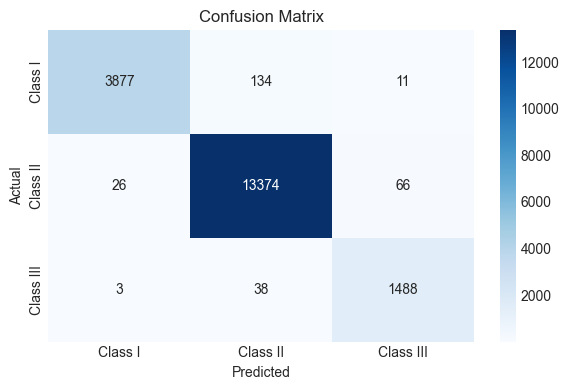

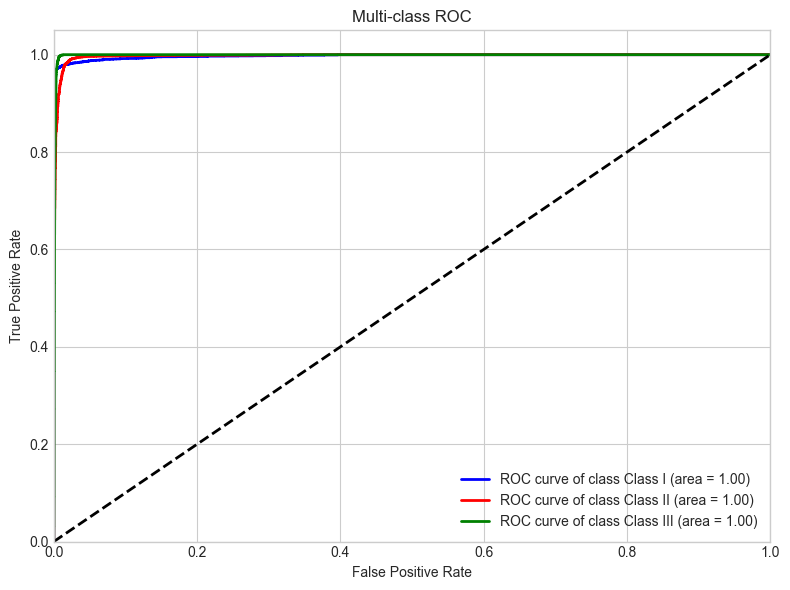

In [10]:
# Best model
best_model = grid_search.best_estimator_

# Predict on test data
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

# Metrics
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# For multi-class problems, we need to use a one-vs-rest approach for ROC curves
# Calculate ROC AUC for each class
n_classes = len(class_names)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_encoded == i, y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
for i, color, cls in zip(range(n_classes), colors, class_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {cls} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

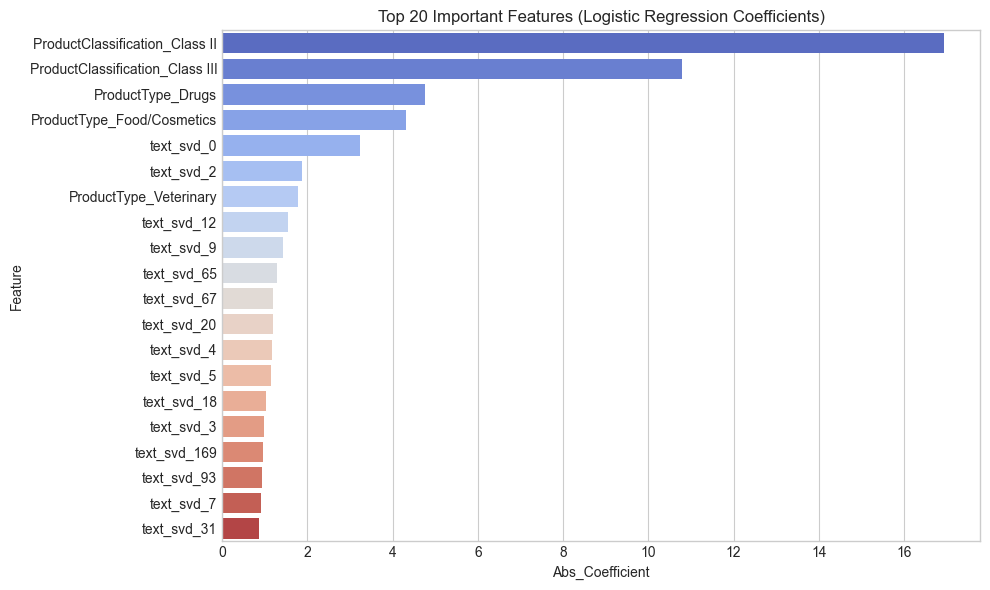

In [12]:
# Extract feature names and coefficients
feature_names = X_train.columns
coefficients = best_model.named_steps['logreg'].coef_[0]  # Changed 'log_reg' to 'logreg'

# Create DataFrame for visualization
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values(by='Abs_Coefficient', ascending=False)

# Plot the top 20 most important features
plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df.head(20), x='Abs_Coefficient', y='Feature', palette='coolwarm')
plt.title("Top 20 Important Features (Logistic Regression Coefficients)")
plt.tight_layout()
plt.show()

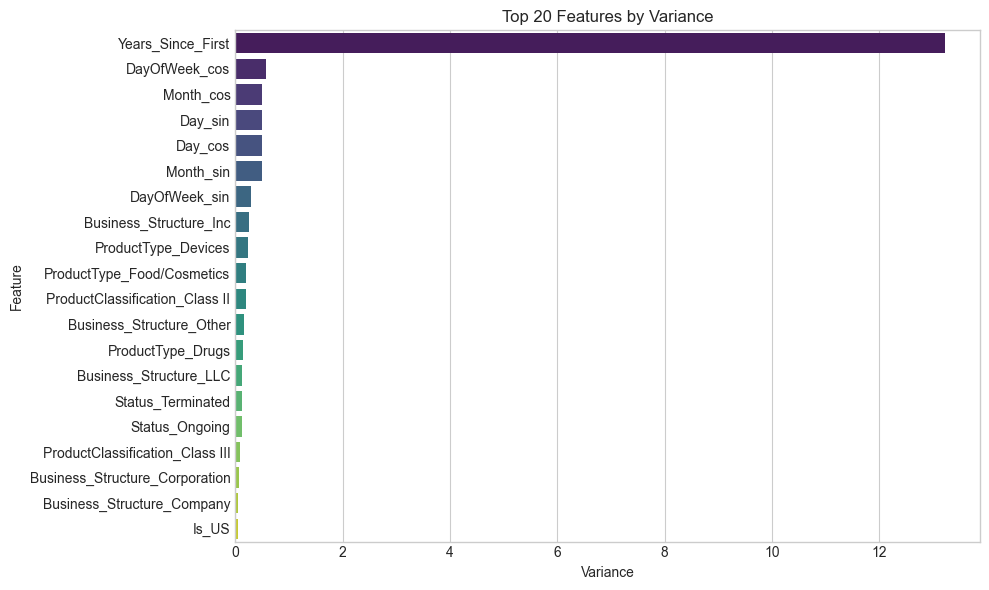

In [13]:
# Feature variance
variance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Variance': X_train.var()
}).sort_values(by='Variance', ascending=False)

# Plot top 20 by variance
plt.figure(figsize=(10, 6))
sns.barplot(data=variance_df.head(20), x='Variance', y='Feature', palette='viridis')
plt.title("Top 20 Features by Variance")
plt.tight_layout()
plt.show()


In [15]:
# Store bootstrap metrics
boot_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

# Number of bootstrap samples
n_iterations = 1000
random_state = 42

for i in range(n_iterations):
    # Resample predictions
    indices = resample(np.arange(len(y_test_encoded)), replace=True, random_state=random_state + i)
    y_true_sample = y_test_encoded[indices]
    y_pred_sample = y_pred[indices]
    
    # Append scores with 'weighted' average for multi-class classification
    boot_metrics['accuracy'].append(accuracy_score(y_true_sample, y_pred_sample))
    boot_metrics['precision'].append(precision_score(y_true_sample, y_pred_sample, average='weighted'))
    boot_metrics['recall'].append(recall_score(y_true_sample, y_pred_sample, average='weighted'))
    boot_metrics['f1'].append(f1_score(y_true_sample, y_pred_sample, average='weighted'))

In [17]:
# Create a summary table
ci_table = pd.DataFrame(columns=['Metric', 'Mean', '95% CI Lower', '95% CI Upper'])
rows_list = []

for metric in boot_metrics:
    scores = boot_metrics[metric]
    mean = np.mean(scores)
    lower = np.percentile(scores, 2.5)
    upper = np.percentile(scores, 97.5)
    
    rows_list.append({
        'Metric': metric.capitalize(),
        'Mean': round(mean, 4),
        '95% CI Lower': round(lower, 4),
        '95% CI Upper': round(upper, 4)
    })

# Create the DataFrame from the list of rows
ci_table = pd.DataFrame(rows_list)

# Display the table
print("\nConfidence Intervals (95%) for Test Set Metrics:")
print(ci_table)


Confidence Intervals (95%) for Test Set Metrics:
      Metric    Mean  95% CI Lower  95% CI Upper
0   Accuracy  0.9854        0.9836        0.9870
1  Precision  0.9855        0.9837        0.9871
2     Recall  0.9854        0.9836        0.9870
3         F1  0.9853        0.9836        0.9870


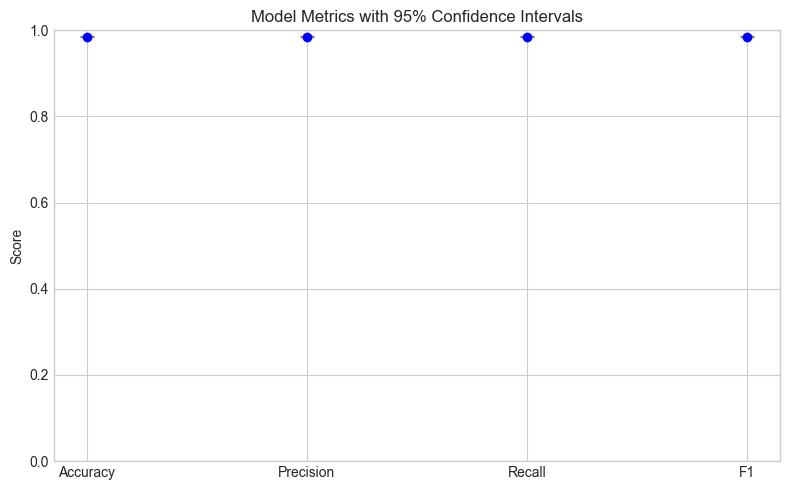

In [18]:
# Plot the confidence intervals
plt.figure(figsize=(8, 5))
plt.errorbar(ci_table['Metric'], ci_table['Mean'],
             yerr=[ci_table['Mean'] - ci_table['95% CI Lower'], ci_table['95% CI Upper'] - ci_table['Mean']],
             fmt='o', capsize=5, color='blue', ecolor='gray', elinewidth=3)

plt.title("Model Metrics with 95% Confidence Intervals")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
# Define parameter grid
param_grid_dt = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the model
dt = DecisionTreeClassifier(random_state=42)

# Grid search
grid_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='f1', n_jobs=-1)
grid_dt.fit(X_train, y_train_encoded)

# Best model
best_dt = grid_dt.best_estimator_
print("\nBest Decision Tree Parameters:")
print(grid_dt.best_params_)



Best Decision Tree Parameters:
{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}



Decision Tree Classification Report:
              precision    recall  f1-score   support

     Class I       1.00      0.92      0.96      4022
    Class II       0.98      0.99      0.98     13466
   Class III       0.93      0.97      0.95      1529

    accuracy                           0.98     19017
   macro avg       0.97      0.96      0.96     19017
weighted avg       0.98      0.98      0.98     19017



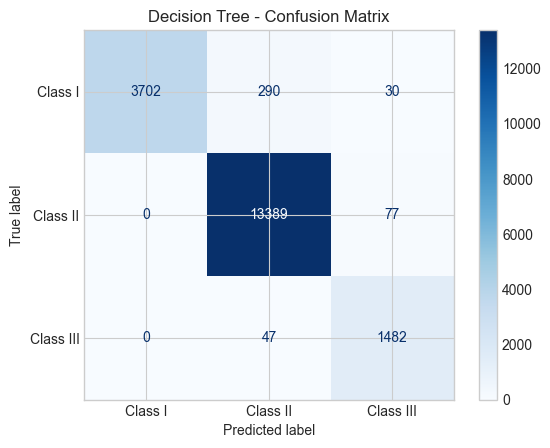

In [20]:
# Predict
y_pred_dt = best_dt.predict(X_test)

# Classification report
print("\nDecision Tree Classification Report:")
print(classification_report(y_test_encoded, y_pred_dt, target_names=class_names))

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(best_dt, X_test, y_test_encoded, display_labels=class_names, cmap='Blues')
plt.title("Decision Tree - Confusion Matrix")
plt.show()


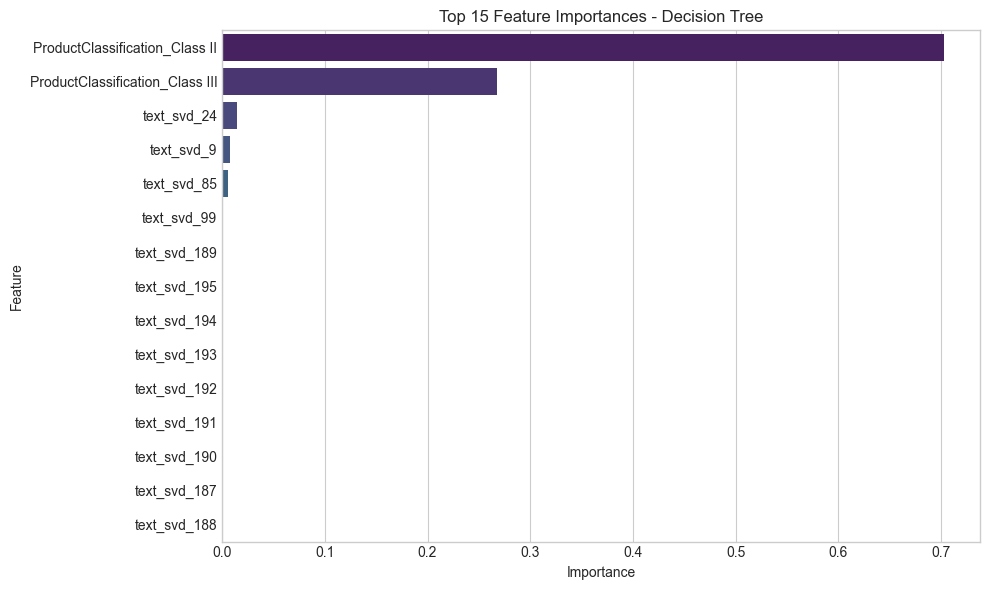

In [21]:
importances_dt = best_dt.feature_importances_
feature_names = X_train.columns

# Create dataframe and sort
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances_dt})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(15)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Top 15 Feature Importances - Decision Tree")
plt.tight_layout()
plt.show()


In [22]:
# Bootstrap function
def bootstrap_metrics(y_true, y_pred, n_bootstraps=1000, alpha=0.95):
    np.random.seed(42)
    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    }

    for _ in range(n_bootstraps):
        indices = resample(range(len(y_true)))
        y_true_sample = np.array(y_true)[indices]
        y_pred_sample = np.array(y_pred)[indices]
        
        metrics['accuracy'].append(accuracy_score(y_true_sample, y_pred_sample))
        metrics['precision'].append(precision_score(y_true_sample, y_pred_sample, average='weighted', zero_division=0))
        metrics['recall'].append(recall_score(y_true_sample, y_pred_sample, average='weighted'))
        metrics['f1'].append(f1_score(y_true_sample, y_pred_sample, average='weighted'))

    # Calculate CIs
    results = {}
    for metric_name, values in metrics.items():
        lower = np.percentile(values, (1 - alpha) / 2 * 100)
        upper = np.percentile(values, (1 + alpha) / 2 * 100)
        mean = np.mean(values)
        results[metric_name] = (mean, lower, upper)

    return results

# Get confidence intervals
dt_ci = bootstrap_metrics(y_test_encoded, y_pred_dt)

# Display nicely as table
ci_df = pd.DataFrame.from_dict(dt_ci, orient='index', columns=['Mean', 'Lower 95% CI', 'Upper 95% CI'])
ci_df.index = ['Accuracy', 'Precision', 'Recall', 'F1-score']
print("\nDecision Tree Confidence Intervals (95%):")
print(ci_df.round(4))



Decision Tree Confidence Intervals (95%):
             Mean  Lower 95% CI  Upper 95% CI
Accuracy   0.9767        0.9744        0.9789
Precision  0.9772        0.9751        0.9794
Recall     0.9767        0.9744        0.9789
F1-score   0.9765        0.9742        0.9788


In [23]:
# Logistic Regression setup
logreg = LogisticRegression(solver='liblinear', max_iter=1000)

# Grid for both L1 and L2 penalties
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Grid search with cross-validation
grid_logreg = GridSearchCV(logreg, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_logreg.fit(X_train, y_train_encoded)

# Best model
best_logreg = grid_logreg.best_estimator_
print(f"\nBest Logistic Regression Parameters: {grid_logreg.best_params_}")



Best Logistic Regression Parameters: {'C': 100, 'penalty': 'l1'}



Classification Report (Logistic Regression):
              precision    recall  f1-score   support

     Class I       0.99      0.96      0.98      4022
    Class II       0.99      0.99      0.99     13466
   Class III       0.95      0.97      0.96      1529

    accuracy                           0.99     19017
   macro avg       0.98      0.98      0.98     19017
weighted avg       0.99      0.99      0.99     19017



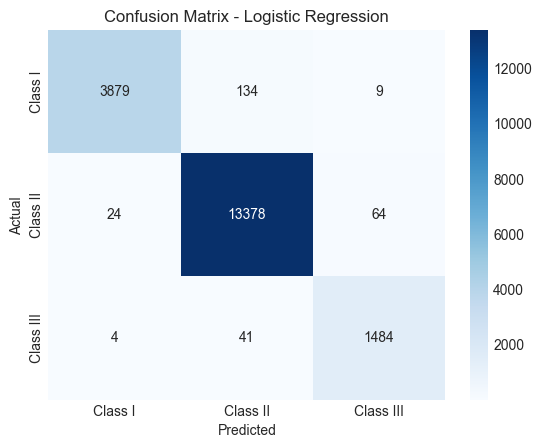

In [24]:
# Predictions
y_pred_logreg = best_logreg.predict(X_test)

# Report
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test_encoded, y_pred_logreg, target_names=class_names))

# Confusion Matrix
conf_matrix_logreg = confusion_matrix(y_test_encoded, y_pred_logreg)
sns.heatmap(conf_matrix_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


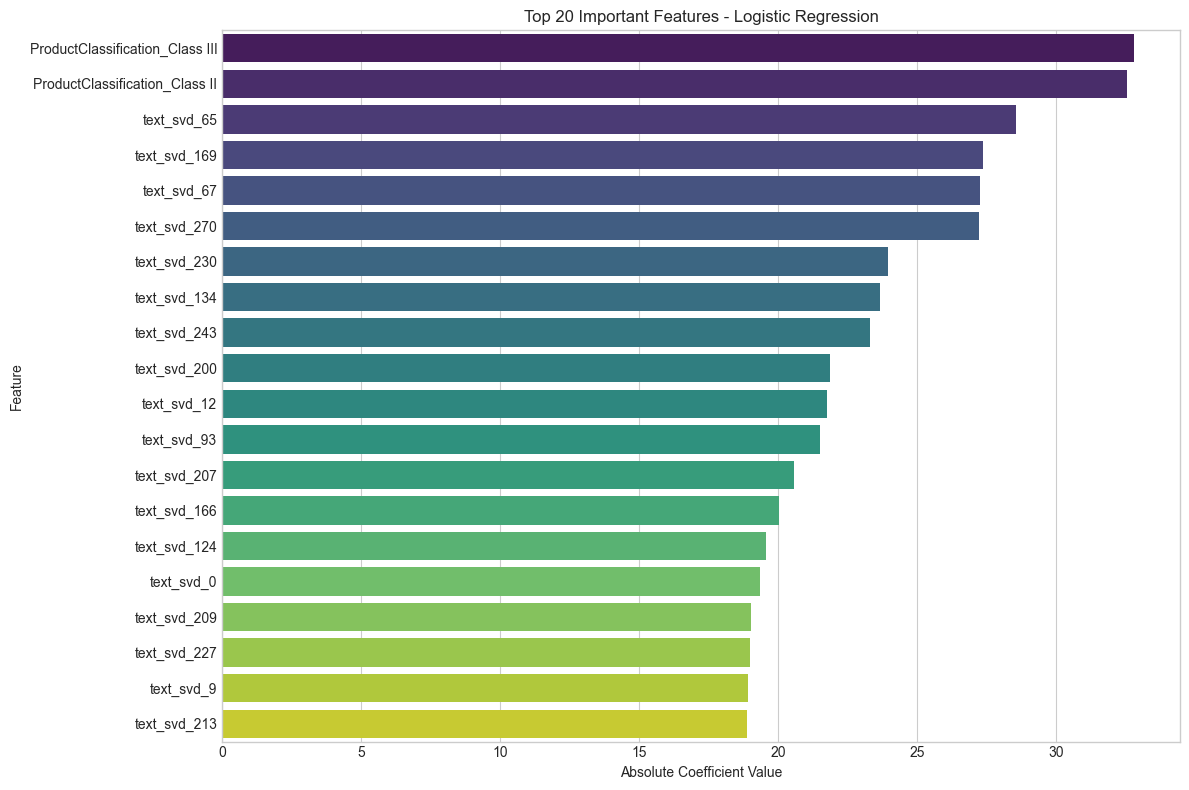

In [25]:
# Coefficients from the best logistic regression model
coefs = best_logreg.coef_[0]
feature_names = X_train.columns

# Create a DataFrame of feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs,
    'Importance (Abs)': np.abs(coefs)
}).sort_values(by='Importance (Abs)', ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance (Abs)', y='Feature', data=importance_df.head(20), palette='viridis')
plt.title('Top 20 Important Features - Logistic Regression')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()



Evaluating Model: Random Forest
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
  Mean Accuracy: 0.9892 ± 0.0004


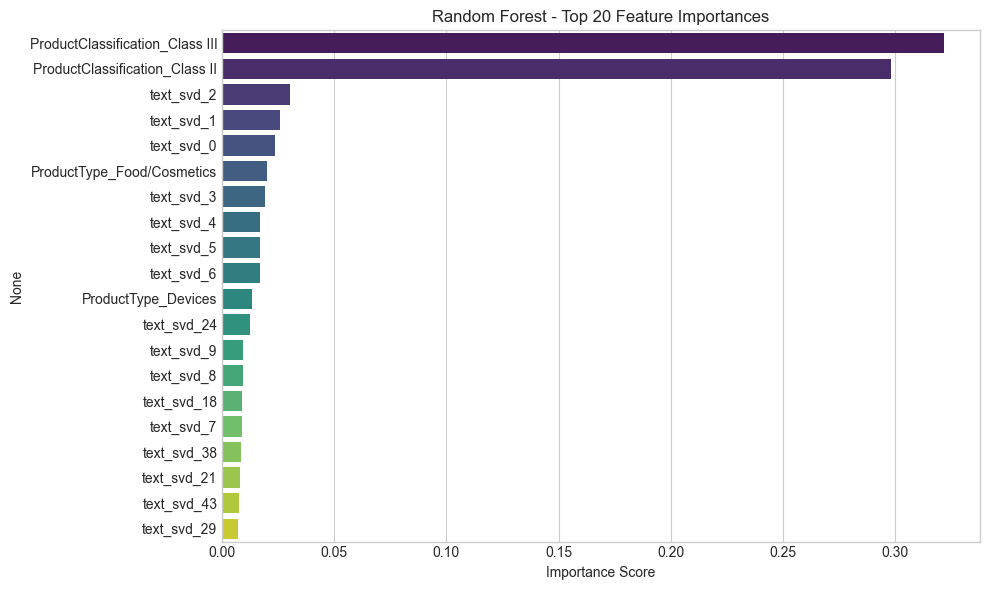


Evaluating Model: XGBoost
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
  Mean Accuracy: 0.9890 ± 0.0010


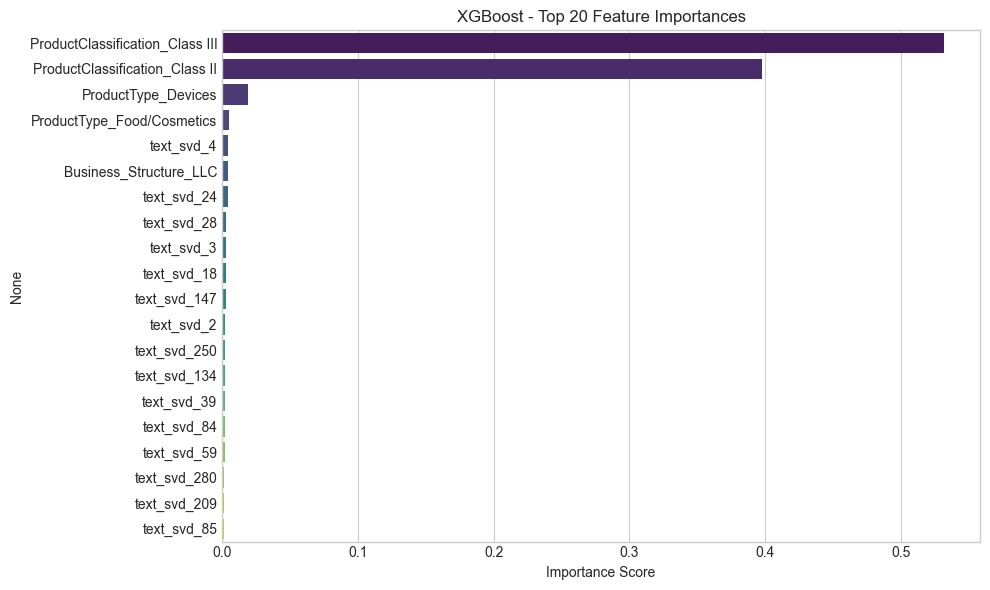


Evaluating Model: CatBoost
  Fold 1/5
  Fold 2/5
  Fold 3/5
  Fold 4/5
  Fold 5/5
  Mean Accuracy: 0.9918 ± 0.0010


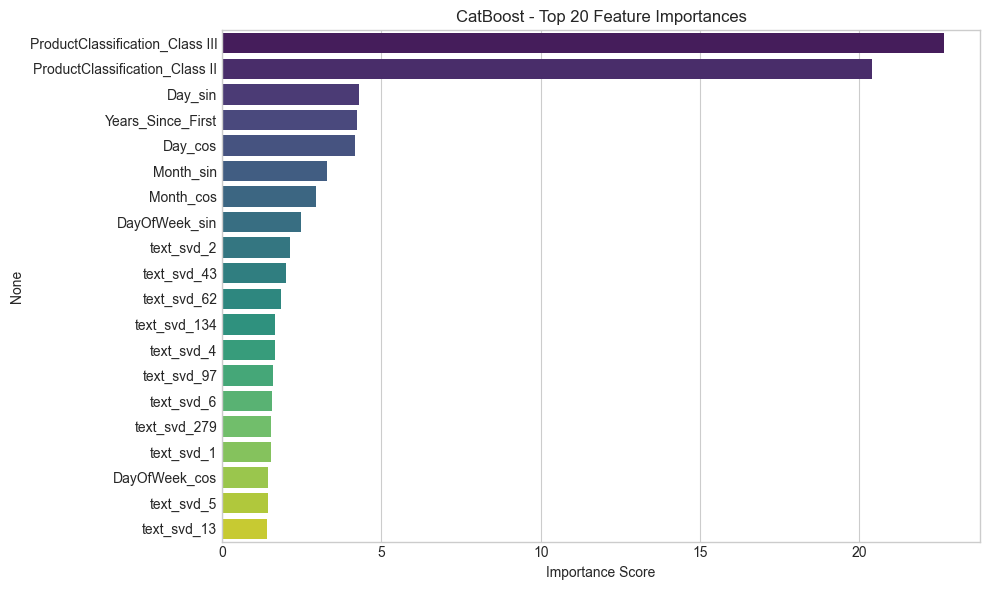

In [26]:
# Helper to plot feature importances
def plot_feature_importance(importances, features, model_name, top_n=20):
    fi = pd.Series(importances, index=features).sort_values(ascending=False).head(top_n)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=fi.values, y=fi.index, palette="viridis")
    plt.title(f"{model_name} - Top {top_n} Feature Importances")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()

# Helper to compute and print mean accuracy with confidence interval
def report_accuracy(fold_scores):
    mean_acc = np.mean(fold_scores)
    ci = sem(fold_scores) * t.ppf((1 + 0.95) / 2., len(fold_scores)-1)
    print(f"  Mean Accuracy: {mean_acc:.4f} ± {ci:.4f}")
    return mean_acc, ci

# Setup
models = {
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(eval_metric='mlogloss', random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42)
}

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Store results
model_results = {}

for name, model in models.items():
    print(f"\n{'='*50}\nEvaluating Model: {name}\n{'='*50}")
    fold_scores = []
    feature_counts = pd.Series(0, index=X_train.columns)

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train_encoded), 1):
        print(f"  Fold {fold}/{n_folds}")

        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train_encoded[train_idx], y_train_encoded[val_idx]

        sm = SMOTE(random_state=42)
        X_tr_resampled, y_tr_resampled = sm.fit_resample(X_tr, y_tr)

        # Feature selection
        selector_model = model.__class__(**model.get_params())
        selector_model.fit(X_tr_resampled, y_tr_resampled)
        selector = SelectFromModel(selector_model, threshold='mean', prefit=True)
        selected_features = X_train.columns[selector.get_support()]
        feature_counts[selected_features] += 1

        X_tr_sel = selector.transform(X_tr_resampled)
        X_val_sel = selector.transform(X_val)

        # Train final model on selected features
        fitted_model = model.__class__(**model.get_params())
        fitted_model.fit(X_tr_sel, y_tr_resampled)
        preds = fitted_model.predict(X_val_sel)
        acc = accuracy_score(y_val, preds)
        fold_scores.append(acc)

    # Final report
    mean_acc, ci = report_accuracy(fold_scores)

    # Feature Importance Plot
    final_selector_model = model.__class__(**model.get_params())
    sm_full = SMOTE(random_state=42)
    X_resampled, y_resampled = sm_full.fit_resample(X_train[selected_features], y_train_encoded)
    final_selector_model.fit(X_resampled, y_resampled)
    plot_feature_importance(final_selector_model.feature_importances_, selected_features, name)

    # Save results
    model_results[name] = {
        'fold_accuracies': fold_scores,
        'mean_accuracy': mean_acc,
        'confidence_interval': ci,
        'feature_importance': feature_counts.sort_values(ascending=False)
    }


In [27]:
# Random Forest Hyperparameter Tuning
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search_rf.fit(X_train, y_train_encoded)
print(f"Best Parameters for RF: {grid_search_rf.best_params_}")
best_rf_model = grid_search_rf.best_estimator_


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters for RF: {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [28]:
# XGBoost Hyperparameter Tuning
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(XGBClassifier(eval_metric='mlogloss', random_state=42), param_grid_xgb, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search_xgb.fit(X_train, y_train_encoded)
print(f"Best Parameters for XGBoost: {grid_search_xgb.best_params_}")
best_xgb_model = grid_search_xgb.best_estimator_


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}


In [ ]:
# CatBoost Hyperparameter Tuning
param_grid_cb = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.1],
    'depth': [6, 10],
    'l2_leaf_reg': [3, 5]
}

grid_search_cb = GridSearchCV(CatBoostClassifier(verbose=0, random_state=42), param_grid_cb, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search_cb.fit(X_train, y_train_encoded)
print(f"Best Parameters for CatBoost: {grid_search_cb.best_params_}")
best_cb_model = grid_search_cb.best_estimator_


Fitting 3 folds for each of 16 candidates, totalling 48 fits


In [ ]:
# Prepare comparison data
model_names = ['Random Forest', 'XGBoost', 'CatBoost']
mean_accuracies = [model_results['Random Forest']['mean_accuracy'], 
                   model_results['XGBoost']['mean_accuracy'], 
                   model_results['CatBoost']['mean_accuracy']]
confidence_intervals = [model_results['Random Forest']['confidence_interval'], 
                        model_results['XGBoost']['confidence_interval'], 
                        model_results['CatBoost']['confidence_interval']]

# Plot the comparison chart
plt.figure(figsize=(8, 5))
plt.bar(model_names, mean_accuracies, yerr=confidence_intervals, capsize=5, color=['blue', 'green', 'red'], alpha=0.7)
plt.ylabel('Mean Accuracy')
plt.title('Model Comparison with Confidence Intervals')
plt.ylim([0, 1])
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()


In [ ]:
# XGBoost Model Evaluation
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_fold_scores = []
xgb_feature_counts = pd.Series(0, index=X_train.columns)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train_encoded), 1):
    print(f"  Fold {fold}/{n_folds} - XGBoost")

    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train_encoded[train_idx], y_train_encoded[val_idx]

    sm = SMOTE(random_state=42)
    X_tr_resampled, y_tr_resampled = sm.fit_resample(X_tr, y_tr)

    # Feature selection
    selector_model = xgb_model.__class__(**xgb_model.get_params())
    selector_model.fit(X_tr_resampled, y_tr_resampled)
    selector = SelectFromModel(selector_model, threshold='mean', prefit=True)
    selected_features = X_train.columns[selector.get_support()]
    xgb_feature_counts[selected_features] += 1

    X_tr_sel = selector.transform(X_tr_resampled)
    X_val_sel = selector.transform(X_val)

    # Train final model on selected features
    fitted_model = xgb_model.__class__(**xgb_model.get_params())
    fitted_model.fit(X_tr_sel, y_tr_resampled)
    preds = fitted_model.predict(X_val_sel)
    acc = accuracy_score(y_val, preds)
    xgb_fold_scores.append(acc)

# Report Results
xgb_mean_acc, xgb_ci = report_accuracy(xgb_fold_scores)

# Feature Importance Plot for XGBoost
final_selector_model = xgb_model.__class__(**xgb_model.get_params())
final_selector_model.fit(X_resampled, y_resampled)
plot_feature_importance(final_selector_model.feature_importances_, selected_features, "XGBoost")


In [ ]:
# CatBoost Model Evaluation
cb_model = CatBoostClassifier(verbose=0, random_state=42)
cb_fold_scores = []
cb_feature_counts = pd.Series(0, index=X_train.columns)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train_encoded), 1):
    print(f"  Fold {fold}/{n_folds} - CatBoost")

    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train_encoded[train_idx], y_train_encoded[val_idx]

    sm = SMOTE(random_state=42)
    X_tr_resampled, y_tr_resampled = sm.fit_resample(X_tr, y_tr)

    # Feature selection
    selector_model = cb_model.__class__(**cb_model.get_params())
    selector_model.fit(X_tr_resampled, y_tr_resampled)
    selector = SelectFromModel(selector_model, threshold='mean', prefit=True)
    selected_features = X_train.columns[selector.get_support()]
    cb_feature_counts[selected_features] += 1

    X_tr_sel = selector.transform(X_tr_resampled)
    X_val_sel = selector.transform(X_val)

    # Train final model on selected features
    fitted_model = cb_model.__class__(**cb_model.get_params())
    fitted_model.fit(X_tr_sel, y_tr_resampled)
    preds = fitted_model.predict(X_val_sel)
    acc = accuracy_score(y_val, preds)
    cb_fold_scores.append(acc)

# Report Results
cb_mean_acc, cb_ci = report_accuracy(cb_fold_scores)

# Feature Importance Plot for CatBoost
final_selector_model = cb_model.__class__(**cb_model.get_params())
final_selector_model.fit(X_resampled, y_resampled)
plot_feature_importance(final_selector_model.feature_importances_, selected_features, "CatBoost")


In [ ]:
# Define parameter grid for hyperparameter tuning
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,)],  # Example layer sizes
    'activation': ['relu', 'tanh'],  # Activation functions
    'solver': ['adam', 'sgd'],  # Optimization solvers
    'alpha': [0.0001, 0.001],  # Regularization
    'learning_rate': ['constant', 'adaptive'],  # Learning rate schedule
}

# Initialize the model
mlp = MLPClassifier(max_iter=1000, random_state=42)

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model from grid search
best_mlp_model = grid_search.best_estimator_

# Print best hyperparameters
print(f"Best Hyperparameters: {grid_search.best_params_}")


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Cross-validation accuracy
cv_accuracy = grid_search.best_score_

# Test accuracy
y_pred = best_mlp_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

# Classification report
class_report = classification_report(y_test, y_pred)

print(f"CV Accuracy: {cv_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Classification Report:")
print(class_report)


In [ ]:
# Add the MLPClassifier results to the comparison table

if baseline_results and hybrid_results:
    print("\n" + "*"*80)
    print("COMPARING BASELINE VS HYBRID VS MLPCLASSIFIER")
    print("*"*80)
    
    # Add MLP results to comparison
    mlp_results = {
        'Model Type': 'MLPClassifier',
        'CV Accuracy': f"{cv_accuracy:.4f}",
        'Test Accuracy': f"{test_accuracy:.4f}",
        'Number of Features': len(X_train.columns)
    }
    
    # Create comparison table
    comparison_df = pd.DataFrame({
        'Metric': ['Model Type', 'CV Accuracy', 'Test Accuracy', 'Number of Features'],
        'Baseline': [
            baseline_results['best_model'],
            f"{baseline_results['cv_accuracy']:.4f}",
            f"{baseline_results['test_accuracy']:.4f}",
            len(baseline_results['best_features'])
        ],
        'Hybrid': [
            hybrid_results['best_model'],
            f"{hybrid_results['cv_accuracy']:.4f}",
            f"{hybrid_results['test_accuracy']:.4f}",
            len(hybrid_results['best_features'])
        ],
        'MLPClassifier': [
            'MLPClassifier',
            f"{cv_accuracy:.4f}",
            f"{test_accuracy:.4f}",
            len(X_train.columns)
        ]
    })
    
    print("\nComparison Summary:")
    print(comparison_df)
    
    # Calculate improvement for MLPClassifier
    accuracy_diff_baseline = test_accuracy - baseline_results['test_accuracy']
    accuracy_diff_hybrid = test_accuracy - hybrid_results['test_accuracy']
    
    print(f"\nAccuracy difference (MLP vs Baseline): {accuracy_diff_baseline:.4f}")
    print(f"Accuracy difference (MLP vs Hybrid): {accuracy_diff_hybrid:.4f}")
    
    # Plot the performance comparison
    metrics = ['CV Accuracy', 'Test Accuracy']
    baseline_values = [baseline_results['cv_accuracy'], baseline_results['test_accuracy']]
    hybrid_values = [hybrid_results['cv_accuracy'], hybrid_results['test_accuracy']]
    mlp_values = [cv_accuracy, test_accuracy]
    
    plt.figure(figsize=(10, 6))
    x = np.arange(len(metrics))
    width = 0.25  # Adjusted width for MLP comparison
    
    plt.bar(x - width, baseline_values, width, label='Baseline')
    plt.bar(x, hybrid_values, width, label='Hybrid')
    plt.bar(x + width, mlp_values, width, label='MLPClassifier')
    
    plt.ylabel('Accuracy')
    plt.title('Performance Comparison: Baseline, Hybrid, and MLPClassifier')
    plt.xticks(x, metrics)
    plt.legend()
    plt.ylim(0.95, 1.0)  # Adjust as needed
    
    plt.savefig('results/comparison_baseline_hybrid_mlp_accuracy.png', dpi=300, bbox_inches='tight')
    plt.close()

    print("\nResults saved. Analysis complete.")


# Comparison

In [ ]:
if baseline_results and hybrid_results:
    print("\n" + "*"*80)
    print("COMPARING BASELINE VS HYBRID MODELS")
    print("*"*80)


In [ ]:
# Create comparison table
comparison_df = pd.DataFrame({
    'Metric': ['Model Type', 'CV Accuracy', 'Test Accuracy', 'Number of Features'],
    'Baseline': [
        baseline_results['best_model'],
        f"{baseline_results['cv_accuracy']:.4f}",
        f"{baseline_results['test_accuracy']:.4f}",
        len(baseline_results['best_features'])
    ],
    'Hybrid': [
        hybrid_results['best_model'],
        f"{hybrid_results['cv_accuracy']:.4f}",
        f"{hybrid_results['test_accuracy']:.4f}",
        len(hybrid_results['best_features'])
    ]
})

print("\nComparison Summary:")
print(comparison_df)


In [ ]:
# Calculate improvement
accuracy_diff = hybrid_results['test_accuracy'] - baseline_results['test_accuracy']
percent_improvement = (accuracy_diff / baseline_results['test_accuracy']) * 100

print(f"\nAccuracy difference: {accuracy_diff:.4f}")
print(f"Percent improvement: {percent_improvement:.2f}%")


In [ ]:
if accuracy_diff > 0:
    print("\nConclusion: The hybrid model (with text features) performs better than the baseline model.")
elif accuracy_diff < 0:
    print("\nConclusion: The baseline model performs better than the hybrid model with text features.")
else:
    print("\nConclusion: Both models perform similarly. Text features did not significantly impact performance.")


In [ ]:
# Class-specific performance comparison
baseline_report = pd.DataFrame(baseline_results['classification_report'])
hybrid_report = pd.DataFrame(hybrid_results['classification_report'])

print("\nClass-specific Performance Comparison:")
for class_name in baseline_report.columns:
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']: 
        print(f"\n{class_name} Performance:")
        for metric in ['precision', 'recall', 'f1-score']:
            baseline_val = baseline_report.loc[metric, class_name]
            hybrid_val = hybrid_report.loc[metric, class_name]
            diff = hybrid_val - baseline_val
            print(f"  {metric}: Baseline={baseline_val:.4f}, Hybrid={hybrid_val:.4f}, Diff={diff:.4f}")


In [ ]:
# Save comparison results
comparison_df.to_csv('results/baseline_vs_hybrid_comparison.csv', index=False)


In [ ]:
# Create performance comparison bar chart
metrics = ['CV Accuracy', 'Test Accuracy']
baseline_values = [baseline_results['cv_accuracy'], baseline_results['test_accuracy']]
hybrid_values = [hybrid_results['cv_accuracy'], hybrid_results['test_accuracy']]

plt.figure(figsize=(10, 6))
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, baseline_values, width, label='Baseline')
plt.bar(x + width/2, hybrid_values, width, label='Hybrid (with text)')

plt.ylabel('Accuracy')
plt.title('Performance Comparison: Baseline vs Hybrid Models')
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0.95, 1.0)  # Adjust as needed to highlight differences

plt.savefig('results/baseline_vs_hybrid_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.close()


In [ ]:
print("\nResults saved. Analysis complete.")
